Epoch [1/1000], Train Loss: 1625808.5417, Test Loss: 1001254.5000
Epoch [2/1000], Train Loss: 1618194.7556, Test Loss: 996164.8125
Epoch [3/1000], Train Loss: 1611272.0225, Test Loss: 990386.8750
Epoch [4/1000], Train Loss: 1604130.3919, Test Loss: 984736.3125
Epoch [5/1000], Train Loss: 1596908.2500, Test Loss: 979058.1250
Epoch [6/1000], Train Loss: 1589695.7354, Test Loss: 973368.1875
Epoch [7/1000], Train Loss: 1582498.0574, Test Loss: 967712.0000
Epoch [8/1000], Train Loss: 1575345.5428, Test Loss: 962099.5000
Epoch [9/1000], Train Loss: 1568244.9403, Test Loss: 956532.0000
Epoch [10/1000], Train Loss: 1561152.7072, Test Loss: 950675.8125
Epoch [11/1000], Train Loss: 1553749.6543, Test Loss: 945151.6250
Epoch [12/1000], Train Loss: 1546736.0642, Test Loss: 939657.1875
Epoch [13/1000], Train Loss: 1539758.2466, Test Loss: 934196.3125
Epoch [14/1000], Train Loss: 1532818.7703, Test Loss: 928769.6875
Epoch [15/1000], Train Loss: 1525917.8007, Test Loss: 923376.6250
Epoch [16/1000], T

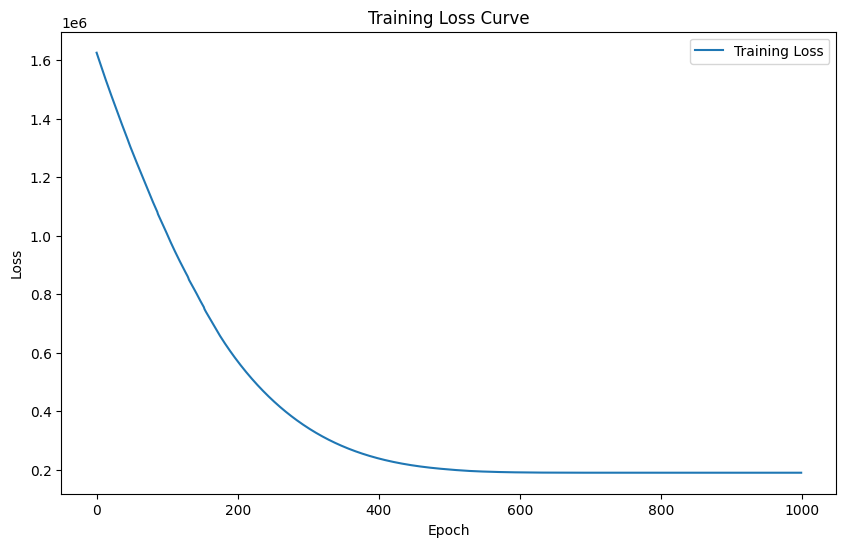

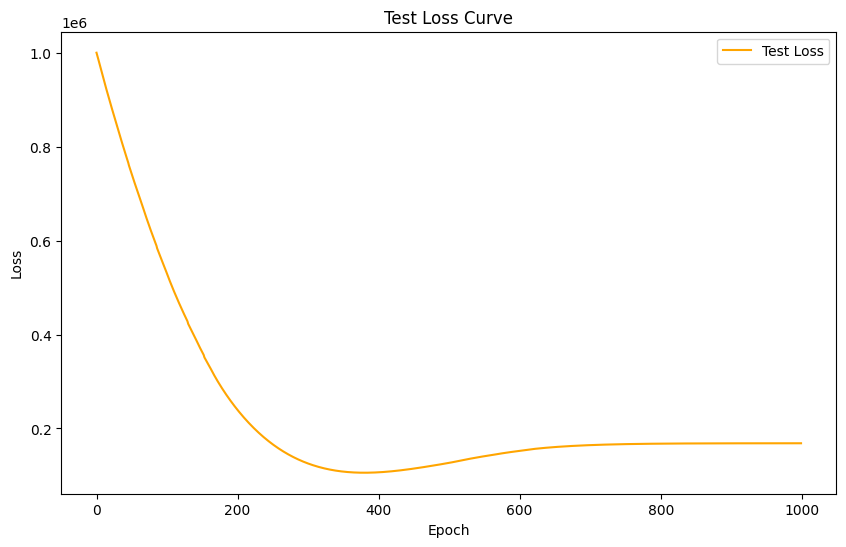

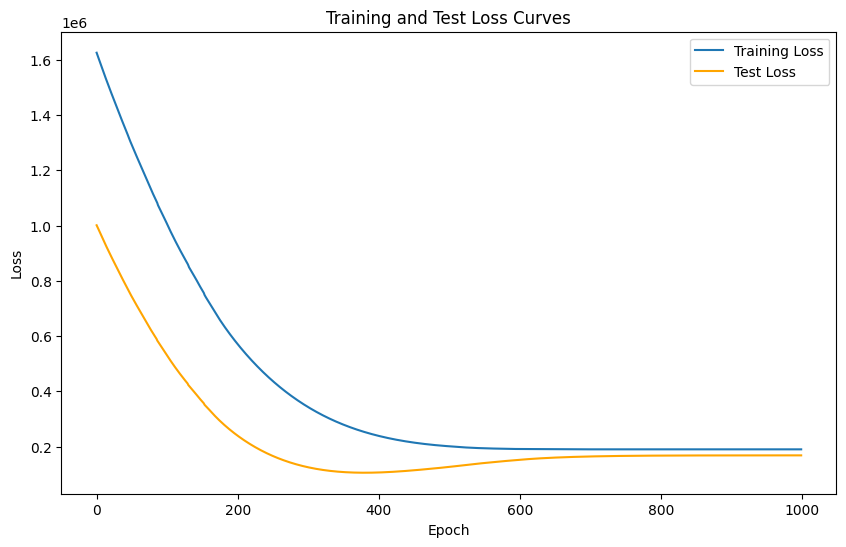

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/FinalProjectDataS23.csv')

# Define window size and split the dataset
window_size = 10
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences and targets
def create_sequences_and_targets(data, window_size, train=True):
    sequences, targets = [], []
    start_index = window_size if train else len(data) - window_size

    for i in range(start_index, len(data)):
        sequence = data[i - window_size:i][['rate', 'ems', 'pkh']].values
        target = data.iloc[i]['pkh']
        sequences.append(sequence)
        targets.append(target)

    return sequences, targets

train_sequences, train_targets = create_sequences_and_targets(train_data, window_size)
test_sequences, test_targets = create_sequences_and_targets(test_data, window_size, train=False)

train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = 3  # rate, ems, pkh
hidden_size = 128
output_size = 1  # predicting pkh
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
batch_size = 32

train_losses = []
test_losses = []
best_train_loss = float('inf')
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0.0
    for i in range(0, len(train_sequences), batch_size):
        batch_sequences = train_sequences[i:i+batch_size]
        batch_targets = train_targets[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(batch_sequences)

    train_loss = epoch_train_loss / len(train_sequences)
    train_losses.append(train_loss)

    # Evaluate on test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_targets.unsqueeze(1))
        test_losses.append(test_loss.item())

    # Track best losses
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Print best losses
print(f'Best Train Loss: {best_train_loss:.4f}, Best Test Loss: {best_test_loss:.4f}')

# Plot training and test loss curves separately
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

# Plot both training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()
